## Comparing $T_w$ and $T_R$
- of the 10 Analytics workload runs on the cluster with 30GB input data and 10 executors
- $SPM$ = serialization cost per MB
- $T_w = (SPM * size)$
- $T_r = (DPM * size)$

### Prerequisites
- VPN connection to the wally cluster
- port forwarding to localhost:18081

In [1]:
import requests

## $T_r$
- in this case $T_r = max(DSP)$ for each Application run
- This is because only when the DataFrame was created from CSV, data was deserialized

In [17]:
HS_URL = "http://localhost:18081/api/v1"
# verify the history server is up by requesting the version
res = requests.get(f"{HS_URL}/version").json()["spark"]
assert res == "3.0.1"
# the DataFrame gets creading reading CSV in the first stage
STAGE_ID = 0
# in this experiment, no stages failed -> only one attempt
STAGE_ATTEMPT_ID = 0
# taken from 30gb_tc_experiment_ana_executions_and_uptime_difference.xlsx
# normal and checkpoint are alternating
APP_IDS = ["spark-9078bc6ddb3a4c0b913072d827c939bc",
           "spark-d493e730d6be481896910ff2a003db4e",
           "spark-827da77e3d5946b395e7359bb0534f22",
           "spark-86ce2033320d452ebfb4c69e0d5aaaad",
           "spark-ab3aa599abf141568bed1c53aee2f842",
           "spark-581a0b09967648cca77d0084ed25af2f",
           "spark-f9330f93633948d195315dbeba6313f2",
           "spark-83e529840d2c4c0eb550105373fed434",
           "spark-af529ab0a80b48168d3c95c60bf7bca7",
           "spark-4c736126ec9a4b72a96a76c1155cd03e"]
Trs = []
for app in APP_IDS:
    task_summary_query = f"{HS_URL}/applications/{app}/stages/{0}/{STAGE_ATTEMPT_ID}/taskSummary?quantiles=0.99"
    res = requests.get(task_summary_query).json()
    # 'executorDeserializeTime' is returned in milliseconds
    tr = res["executorDeserializeTime"][0] / 60000
    Trs.append(tr)
Tr_obj = dict(zip(APP_IDS, Trs))
print(Tr_obj)

{'spark-9078bc6ddb3a4c0b913072d827c939bc': 1.0678, 'spark-d493e730d6be481896910ff2a003db4e': 0.9914, 'spark-827da77e3d5946b395e7359bb0534f22': 1.1017, 'spark-86ce2033320d452ebfb4c69e0d5aaaad': 1.0551666666666666, 'spark-ab3aa599abf141568bed1c53aee2f842': 0.9929166666666667, 'spark-581a0b09967648cca77d0084ed25af2f': 1.0306166666666667, 'spark-f9330f93633948d195315dbeba6313f2': 1.07945, 'spark-83e529840d2c4c0eb550105373fed434': 0.9673333333333334, 'spark-af529ab0a80b48168d3c95c60bf7bca7': 1.0732166666666667, 'spark-4c736126ec9a4b72a96a76c1155cd03e': 1.0506}


## $T_w$
- taken from `gbt_analytics_cluster_experiments-large.ipynb`

In [15]:
# first 5 runs were normal runs hence there was no T_w
TCS = [0,0,0,0,0,19.93333339691162, 16.23333317041397, 16.566666960716248, 17.616666793823242, 17.616666793823242]

Tc_obj = dict(zip(APP_IDS, TCS))
print(Tc_obj)

{'spark-9078bc6ddb3a4c0b913072d827c939bc': 0, 'spark-d493e730d6be481896910ff2a003db4e': 0, 'spark-827da77e3d5946b395e7359bb0534f22': 0, 'spark-86ce2033320d452ebfb4c69e0d5aaaad': 0, 'spark-ab3aa599abf141568bed1c53aee2f842': 0, 'spark-581a0b09967648cca77d0084ed25af2f': 19.93333339691162, 'spark-f9330f93633948d195315dbeba6313f2': 16.23333317041397, 'spark-83e529840d2c4c0eb550105373fed434': 16.566666960716248, 'spark-af529ab0a80b48168d3c95c60bf7bca7': 17.616666793823242, 'spark-4c736126ec9a4b72a96a76c1155cd03e': 17.616666793823242}


## plot results

<ipython-input-46-ab822fa49efb>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 45)


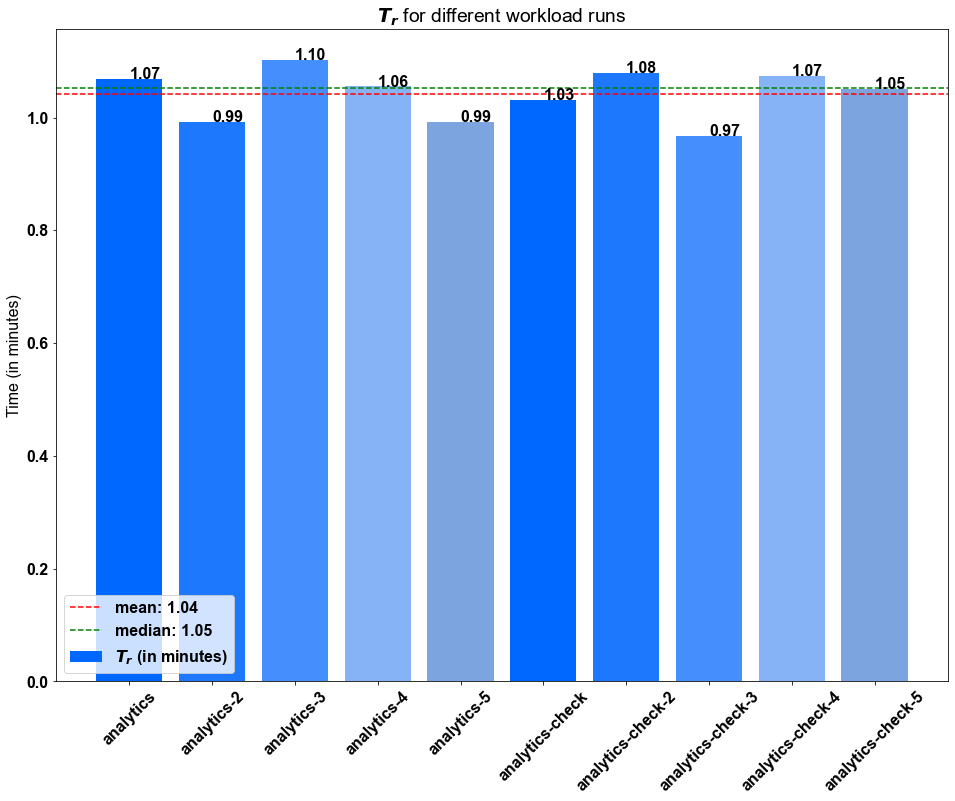

In [46]:
import matplotlib.pyplot as plt
import numpy as np
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)


labels = ['analytics', 'analytics-2', 'analytics-3', 'analytics-4', 'analytics-5', 'analytics-check', 'analytics-check-2', 'analytics-check-3', 'analytics-check-4', 'analytics-check-5']

mean = np.mean(Trs)
median = np.median(Trs)


fig, ax = plt.subplots()
fig.set_size_inches(16, 12)

ax.bar(labels, Trs, label='$T_r$ (in minutes)', color=["#0067ff", "#1e78fd", "#448ffd", "#86b3f5", "#7ca4de"])
plt.axhline(mean, color='r', linestyle='--', label=f"mean: {str(format(mean, '.2f'))}")
plt.axhline(median, color='g', linestyle='--', label=f"median: {str(format(median, '.2f'))}")
# annotate the values to the bars
for i, j  in zip(labels, Trs):
    ax.annotate(str(format(j, '.2f')),xy=(i,j))

ax.set_ylabel("Time (in minutes)")
ax.set_title('$T_r$ for different workload runs')
ax.set_xticklabels(labels, rotation = 45)
plt.legend()
# this overwrites
plt.savefig("/Users/fschnei4/TUB_Master_ISM/SoSe21/MA/msc-thesis-saft-experiments/evaluation/plots/tr.pdf", format="pdf")
plt.show()

<ipython-input-68-549c797578ac>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 45)


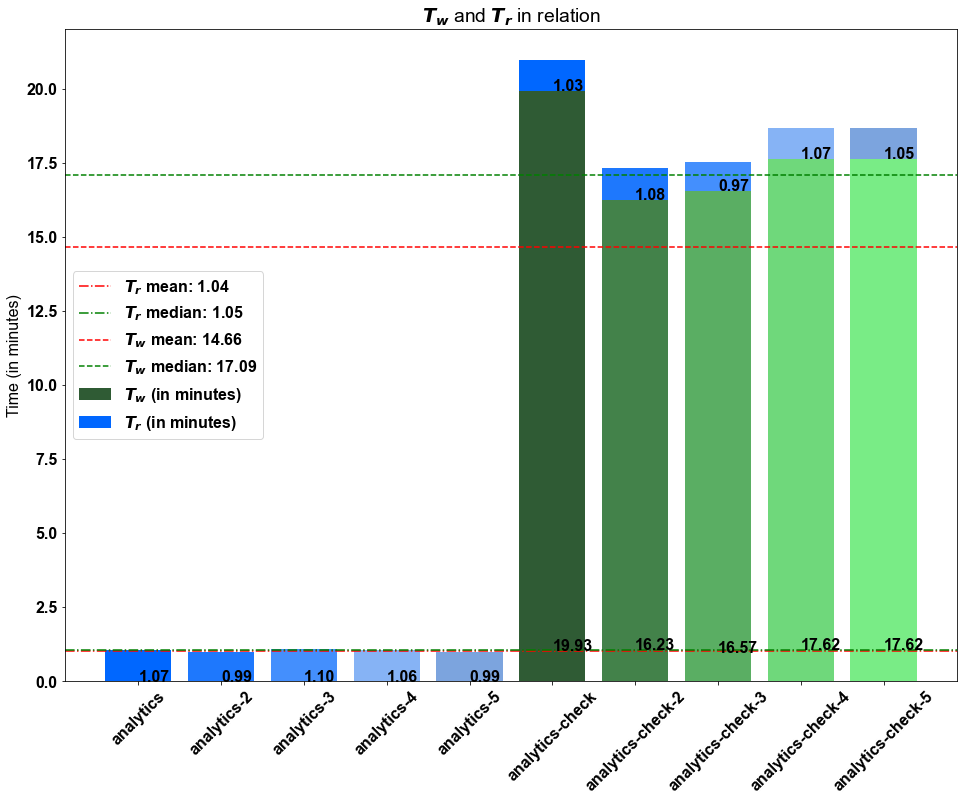

In [68]:
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)


labels = ['analytics', 'analytics-2', 'analytics-3', 'analytics-4', 'analytics-5', 'analytics-check', 'analytics-check-2', 'analytics-check-3', 'analytics-check-4', 'analytics-check-5']

tc_mean = np.mean(TCS[4:10])
tc_median = np.median(TCS[4:10])

fig, ax = plt.subplots()
fig.set_size_inches(16, 12)

ax.bar(labels, TCS, label="$T_w$ (in minutes)", color=["#2f5b34", "#43824a", "#5aae63", "#6fd87b", "#79ec86"])
ax.bar(labels, Trs, label='$T_r$ (in minutes)', bottom=TCS, color=["#0067ff", "#1e78fd", "#448ffd", "#86b3f5", "#7ca4de"])
plt.axhline(mean, color='r', linestyle='-.', label=f"$T_r$ mean: {str(format(mean, '.2f'))}")
plt.axhline(median, color='g', linestyle='-.', label=f"$T_r$ median: {str(format(median, '.2f'))}")
plt.axhline(tc_mean, color='r', linestyle='--', label=f"$T_w$ mean: {str(format(tc_mean, '.2f'))}")
plt.axhline(tc_median, color='g', linestyle='--', label=f"$T_w$ median: {str(format(tc_median, '.2f'))}")
# annotate the values to the bars
for i, j, k in zip(labels, TCS, Trs):
    # skip the checkpoint annotations for non-checkpoint runs
    if j != 0:
        ax.annotate(str(format(k, '.2f')),xy=(i,j))
        ax.annotate(str(format(j, '.2f')),xy=(i,k))
    else:
        ax.annotate(str(format(k, '.2f')),xy=(i,j))

ax.set_ylabel("Time (in minutes)")
ax.set_title('$T_w$ and $T_r$ in relation')
ax.set_xticklabels(labels, rotation = 45)
plt.legend()
# this overwrites
plt.savefig("/Users/fschnei4/TUB_Master_ISM/SoSe21/MA/msc-thesis-saft-experiments/evaluation/plots/tw_tr.pdf", format="pdf")
plt.show()

## $T_w$ and $T_r$ ratio

In [71]:
ratio = tc_median / mean
print(ratio)


16.418192616155064
